<div class="alert alert-info">
    <h1><strong>EQCI Day 13: </strong>Assignment</h1>
    <h2>VQE for Chemistry</h2>
</div>

In [2]:
# Imports!
from qiskit import Aer, IBMQ
from qiskit_nature.drivers import PySCFDriver, UnitsType, Molecule
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import JordanWignerMapper
from qiskit_nature.algorithms import GroundStateEigensolver
from qiskit_nature.algorithms import VQEUCCFactory
from qiskit.algorithms import NumPyMinimumEigensolver
from qiskit_optimization.applications import Knapsack
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit.algorithms import VQE
from qiskit.circuit.library import TwoLocal
from qiskit.utils import QuantumInstance
import numpy as np
import matplotlib.pyplot as plt
from qiskit.circuit.library import EfficientSU2, QAOAAnsatz
from qiskit.algorithms.optimizers import SPSA, COBYLA
from qiskit.providers.aer.noise import NoiseModel
provider = IBMQ.load_account()
print("Libraries imported successfully")
%matplotlib widget

Libraries imported successfully


# Finding the structure of a molecule

## How this challenge works:
This notebook is right at the limit of what qiskit can do, and therefore it is quite tempermental - things may break, bugs may have to be fixed, that's a Hackathon!

1. Run the cells and understand how molecules are simulated, change things around, see what happens!
2. Find the **Ground State Bond Length** of a hydrogen molecule.
3. Apply a noise model to the simulator to simulate as realistically as possible to a real quantum computer

## Defining the system

The first step is to define the molecular system. In the following we ask for the electronic part of a hydrogen molecule.

Qiskit is interfaced with different classical codes which are able to find the molecular structure. Interfacing between Qiskit and the following codes is already available: Gaussian, Psi4, PyQuante, PySCF.

In the following we set up a PySCF driver, for the hydrogen molecule with the two atoms at a distance of 0.8 angstrom from each other.

In [3]:
#Block 7 - Specifying the parameters of the molecule
molecule = Molecule(geometry=[['H', [0., 0., 0.]],
                              ['H', [0., 0., 0.8]]],
                     charge=0, multiplicity=1)    # You can vary the distance between the atoms by changing 0.8
structure_problem = PySCFDriver(molecule = molecule, unit=UnitsType.ANGSTROM)
qubit_converter = QubitConverter(JordanWignerMapper())

/tmp/ipykernel_228/1377952087.py:5: DeprecationWarning: The PySCFDriver class is deprecated as of version 0.2.0 and will be removed no sooner than 3 months after the release. Instead use the PySCFDriver class from qiskit_nature.drivers.second_quantization.pyscfd.
  structure_problem = PySCFDriver(molecule = molecule, unit=UnitsType.ANGSTROM)


## NumPyMinimumEigensolver

A solver is the algorithm through which the ground state is computed.

Let’s first start with a purely classical example: the NumPy minimum eigensolver. This algorithm exactly solves the structure for the molecule. The hydrogen molecule is small enough that we can solve it exactly using a classical solver. Although the classical solver scales badly, i.e., it takes a very long time to solve larger molecules, it can be used on small systems to check the results of the quantum algorithms.

Run the block below to solve the problem using the classical solver.

In [6]:
#Block 8 - Solving using classical solver
method = NumPyMinimumEigensolver()

calc = GroundStateEigensolver(qubit_converter, method)
result = calc.solve(ElectronicStructureProblem(structure_problem))
print("Total energy = ", result.total_energies)

Total energy =  [-1.13414767]


The most important number here is the total energy. Keep it in mind! We will compare the result we get with the VQE solver with this result.

## VQE Solver

Now, we are going to find the energy of this molecule using VQE. To simulate the performance on a real device, let's create a noise model based on ibmq_belem just as we had done in the benchmarking lab.

In [7]:
# Block 9 - Defining a noise model 
backend_belem = provider.get_backend('ibmq_belem')   # Specifying which backend to use
noise_model_belem = NoiseModel.from_backend(backend_belem)  # Creating a noise model from this backend.

Next, we are going to set up VQE. THis is very similar to the setup we had done for the knapsack problem. Below, we have defined a tunable circuit and a classical optimizer and put those together using Qiskit's VQE function.

Don't worry about `QuantumInstance` - it is a way in Qiskit to specify the backend and the noise model together for the VQE simulation.

In [8]:
#Block 10 - Setting up VQE

qinstance = QuantumInstance(backend=Aer.get_backend('qasm_simulator'))

tunable_circuit = EfficientSU2(reps= 1, entanglement='full') # This is the tunable circuit - this is the quantum part of VQE
optimizer = COBYLA(maxiter=500) # Classical optimizer - this is the classical part of VQE
method = VQE(ansatz = tunable_circuit, optimizer = optimizer, quantum_instance = qinstance)# Putting everything together using Qiskit's VQE function

Finally, it's time to find the energy of this structure and print the results!

In [9]:
#Block 11 - Solving using VQE
calc = GroundStateEigensolver(qubit_converter, method)
result = calc.solve(ElectronicStructureProblem(structure_problem))

In [10]:
# Block 12 - Printing results
print("Total energy = ", result.total_energies)
print("Error = ", (-1.13728568 - result.total_energies)/(-1.13728568)*100) 

Total energy =  [-1.11085034]
Error =  [2.324424]


How does the total energy here compare with the exact solution?

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

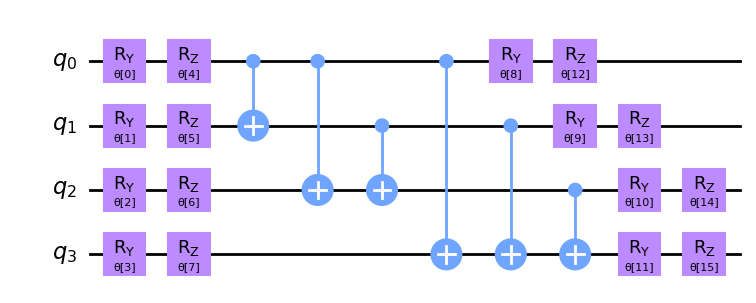

In [11]:
# Block 13 - Drawing the tunable circuit
tunable_circuit.decompose().draw()

# Challenge: Find the Ground State energy of a hyrogen molecule

Above we showed you how we can find the energy for one distance between the hydrogen atoms.

Now, it's your turn to find the energies for many distances, and in the process, find the lowest possible energy. 

Measure the energy across these distances:

`distances = [0.1,0.3,0.5,0.7,0.9,1.1,1.3,1.5,1.7,1.9,2.1,2.3,2.5]`


The distance at which we get the lowest energy corresponds to the ground state bond length of the hydrogen molecule!

## Practice drawing graphs:

You will need to be able to show your results on a graph.
Here is an example graph:

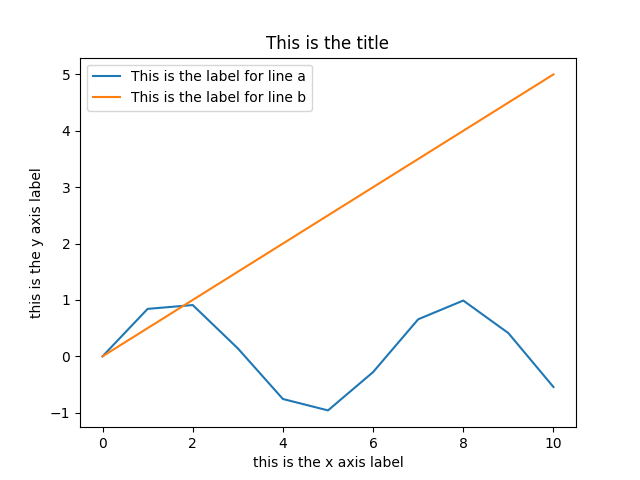

In [9]:
fig, ax = plt.subplots()

# Data Values
a_x = [0,1,2,3,4,5,6,7,8,9,10]
a_y = np.sin(a_x)
b_x = [0,1,2,3,4,5,6,7,8,9,10]
b_y = np.array(b_x) * 0.5

# This plots the lines
ax.plot(a_x, a_y, label="This is the label for line a")
ax.plot(b_x, b_y, label="This is the label for line b")

# This adds labels to axis and title
ax.set_xlabel("this is the x axis label")
ax.set_ylabel("this is the y axis label")
ax.set_title("This is the title")

# This draws a legend
ax.legend()

# This tells jupyter notebook to show the graph
plt.show()

## Solve with both Classical and Quantum Eigensolvers
## Display your results in a graph
1. The Y axis should represent energy, the X axis should be distance
2. There should be two lines representing the different computed energies across bond lengths for both Classical and Quantum
3. **You should also print the length corresponding to the lowest energy**

In [14]:
#Block 14 - Creating energy diagram using classical solver

In [13]:
#Block 15 - Obtaining VQE energy diagram

In [12]:
#Block 16 - Plotting VQE and Classical energy diagram for Hydrogen 

# Note for errors
We have found that the `qasm_simulator` occasionally produces strange results. If you have issues we suggest that you try:

`backend = Aer.get_backend('statevector_simulator')`

### © 2022 The Coding School

**All rights reserved**

*Use of this activity is for personal use only. Copying, reproducing, distributing, posting or sharing this activity in any manner with any third party are prohibited under the terms of this registration. All rights not specifically licensed under the registration are reserved.*